### CSCN8020 – Assignment 2: Q-Learning on Taxi-v3

**Student:** Preetpal Singh  

**StudentID:** 8804336


This notebook satisfies the required deliverables:
- Q-Learning implementation
- Baseline + hyperparameter sweeps
- Metrics/plots + best configuration selection


### Setup
Run once on your local machine to install dependencies.

In [1]:

# If already installed, you can skip.
!python -m pip install --upgrade pip
!python -m pip install gymnasium "gymnasium[toy_text]" numpy matplotlib


## 1) Q-Learning Implementation

In [2]:

import time, json, csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

def epsilon_greedy(q, s, epsilon, n_actions, rng):
    if rng.random() < epsilon:
        return rng.integers(0, n_actions)
    return int(np.argmax(q[s]))

def q_learning(env_name="Taxi-v3", episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.1, seed=42, render_every=None):
    env = gym.make(env_name)
    rng = np.random.default_rng(seed)
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q = np.zeros((n_states, n_actions), dtype=np.float32)
    ep_returns, ep_lengths = [], []
    for ep in range(episodes):
        s, info = env.reset(seed=seed + ep)
        done = False
        total_return = 0.0
        steps = 0
        while not done:
            a = epsilon_greedy(q, s, epsilon, n_actions, rng)
            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated
            td_target = r + gamma * np.max(q[s2]) * (0.0 if done else 1.0)
            td_error = td_target - q[s, a]
            q[s, a] += alpha * td_error
            total_return += r
            s = s2
            steps += 1
        ep_returns.append(total_return)
        ep_lengths.append(steps)
        if render_every is not None and (ep+1) % render_every == 0:
            print(f"[{ep+1:5d}/{episodes}] Return={total_return:.1f}, Steps={steps}")
    env.close()
    return q, np.array(ep_returns, dtype=np.float32), np.array(ep_lengths, dtype=np.int32)

def moving_avg(x, k=50):
    if len(x) < k:
        return x.copy()
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[k:] - cumsum[:-k]) / float(k)

def run_and_log(episodes, alpha, gamma, epsilon, outdir, tag, seed=42):
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
    t0 = time.time()
    q, returns, lengths = q_learning(episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon, seed=seed)
    dt = time.time() - t0
    avg_returns = moving_avg(returns, k=min(50, len(returns)))

    # CSV
    csv_path = outdir / f"{tag}_metrics.csv"
    with open(csv_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["episode", "return", "steps"])
        for i, (r, s) in enumerate(zip(returns, lengths), start=1):
            writer.writerow([i, float(r), int(s)])

    # Plot
    plt.figure()
    plt.plot(returns, label="Return per episode")
    if len(avg_returns) > 0:
        import numpy as _np
        x = _np.arange(len(avg_returns)) + 1 + (len(returns) - len(avg_returns))
        plt.plot(x, avg_returns, label="Moving average (window=50)")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.title(f"Taxi-v3 Q-Learning | α={alpha}, ε={epsilon}, γ={gamma}")
    plt.legend()
    plot_path = outdir / f"{tag}_plots.png"
    plt.savefig(plot_path, bbox_inches="tight"); plt.close()

    # Q-table
    np.save(outdir / f"{tag}_qtable.npy", q)

    summary = {
        "episodes": int(episodes),
        "alpha": float(alpha),
        "epsilon": float(epsilon),
        "gamma": float(gamma),
        "mean_return": float(np.mean(returns[-100:])) if len(returns) >= 100 else float(np.mean(returns)),
        "mean_steps": float(np.mean(lengths[-100:])) if len(lengths) >= 100 else float(np.mean(lengths)),
        "train_time_sec": float(dt),
        "csv_path": str(csv_path),
        "plot_path": str(plot_path),
    }
    with open(outdir / f"{tag}_summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    print(f"Saved: {csv_path.name}, {plot_path.name}")
    return summary


## 2) Run Baseline

In [3]:

from pathlib import Path, PurePosixPath
import time, json

timestamp = time.strftime("%Y%m%d-%H%M%S")
outdir = Path("runs") / timestamp
print("Output dir:", outdir)

base = run_and_log(episodes=5000, alpha=0.1, gamma=0.9, epsilon=0.1, outdir=outdir, tag=f"base_a0.1_e0.1_g0.9")

# Save overall_summary.json scaffold (will be updated by sweeps below)
with open(outdir / "overall_summary.json", "w") as f:
    json.dump({"best": base, "runs": [base]}, f, indent=2)
print("Baseline complete.")


Output dir: runs\20251016-210618
Saved: base_a0.1_e0.1_g0.9_metrics.csv, base_a0.1_e0.1_g0.9_plots.png
Baseline complete.


## 3) Hyperparameter Sweeps

In [4]:

import json
# Learning-rate sweep
lr_runs = []
for a in [0.01, 0.001, 0.2]:
    lr_runs.append(run_and_log(episodes=5000, alpha=a, gamma=0.9, epsilon=0.1, outdir=outdir, tag=f"sweep_alpha_{a}"))

# Exploration sweep
eps_runs = []
for e in [0.2, 0.3]:
    eps_runs.append(run_and_log(episodes=5000, alpha=0.1, gamma=0.9, epsilon=e, outdir=outdir, tag=f"sweep_epsilon_{e}"))

# Compute best
all_runs = [base] + lr_runs + eps_runs
best = max(all_runs, key=lambda d: d["mean_return"])

with open(outdir / "overall_summary.json", "w") as f:
    json.dump({"best": best, "runs": all_runs}, f, indent=2)

print("Best configuration:", best)


Saved: sweep_alpha_0.01_metrics.csv, sweep_alpha_0.01_plots.png
Saved: sweep_alpha_0.001_metrics.csv, sweep_alpha_0.001_plots.png
Saved: sweep_alpha_0.2_metrics.csv, sweep_alpha_0.2_plots.png
Saved: sweep_epsilon_0.2_metrics.csv, sweep_epsilon_0.2_plots.png
Saved: sweep_epsilon_0.3_metrics.csv, sweep_epsilon_0.3_plots.png
Best configuration: {'episodes': 5000, 'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.9, 'mean_return': 1.9800000190734863, 'mean_steps': 15.06, 'train_time_sec': 17.96415615081787, 'csv_path': 'runs\\20251016-210618\\base_a0.1_e0.1_g0.9_metrics.csv', 'plot_path': 'runs\\20251016-210618\\base_a0.1_e0.1_g0.9_plots.png'}


## 4) Load Final Summary

In [5]:

import json
from pathlib import Path

# Load newest overall_summary.json
runs = Path("runs")
if runs.exists():
    latest = max([p for p in runs.iterdir() if p.is_dir()], key=lambda p: p.stat().st_mtime)
    with open(latest / "overall_summary.json", "r") as f:
        overall = json.load(f)
    print("Newest run folder:", latest)
    print("\nBest configuration:"); print(overall["best"])
    print("\nAll runs:"); 
    for r in overall["runs"]:
        print(r)
else:
    print("No runs found. Execute the training cells first.")


Newest run folder: runs\20251016-210618

Best configuration:
{'episodes': 5000, 'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.9, 'mean_return': 1.9800000190734863, 'mean_steps': 15.06, 'train_time_sec': 17.96415615081787, 'csv_path': 'runs\\20251016-210618\\base_a0.1_e0.1_g0.9_metrics.csv', 'plot_path': 'runs\\20251016-210618\\base_a0.1_e0.1_g0.9_plots.png'}

All runs:
{'episodes': 5000, 'alpha': 0.1, 'epsilon': 0.1, 'gamma': 0.9, 'mean_return': 1.9800000190734863, 'mean_steps': 15.06, 'train_time_sec': 17.96415615081787, 'csv_path': 'runs\\20251016-210618\\base_a0.1_e0.1_g0.9_metrics.csv', 'plot_path': 'runs\\20251016-210618\\base_a0.1_e0.1_g0.9_plots.png'}
{'episodes': 5000, 'alpha': 0.01, 'epsilon': 0.1, 'gamma': 0.9, 'mean_return': -72.22000122070312, 'mean_steps': 70.81, 'train_time_sec': 71.29939150810242, 'csv_path': 'runs\\20251016-210618\\sweep_alpha_0.01_metrics.csv', 'plot_path': 'runs\\20251016-210618\\sweep_alpha_0.01_plots.png'}
{'episodes': 5000, 'alpha': 0.001, 'epsilon': 0.


## 5) Plots & Discussion

- Discuss observations (convergence, stability, steps trend).
- Explain why your chosen (α, ε) performed best.
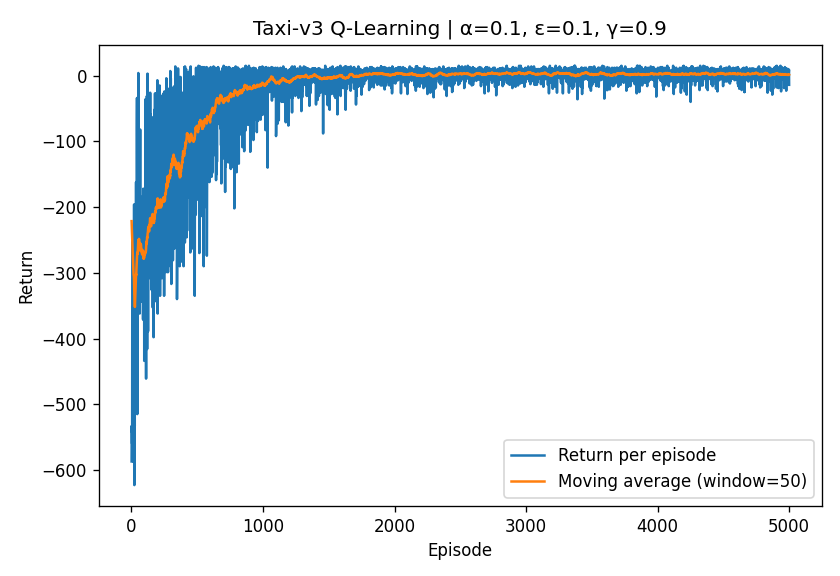
[text](c:/Users/Dell/Desktop/AAAA/runs/20251016-220211/overall_summary.json)
